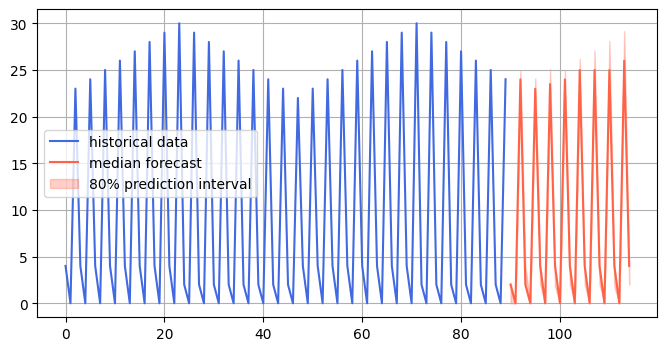

Forecast Shape: torch.Size([1, 20, 25])
Forecast Shape: torch.Size([1, 25])
Shape of embeddings_np: (1, 91, 1024)
New Shape of embeddings_np: (91, 1024)


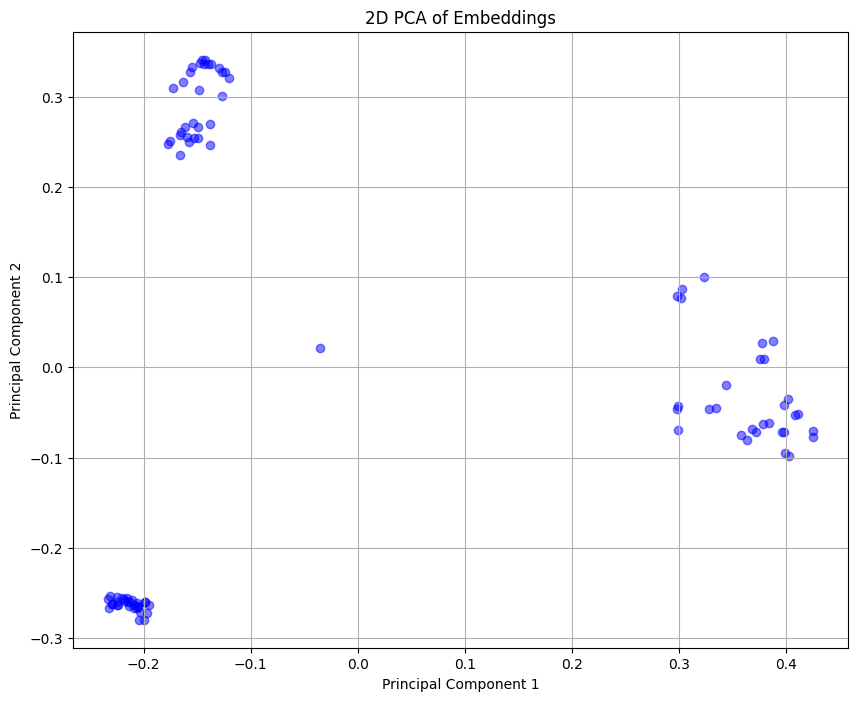

In [49]:
import pandas as pd  # requires: pip install pandas
import torch
from chronos import ChronosPipeline


forecast_len = 25

pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="cpu",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)

#df = pd.read_csv("https://www.tenagolabs.com/crypto_interlace")
df = pd.read_csv("/Users/diamond/Downloads/Chronos_Interlace.csv")

# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
# forecast shape: [num_series, num_samples, prediction_length]
forecast = pipeline.predict(
    context=torch.tensor(df["#Interlaced"]),
    #top_p=.8,
    prediction_length=forecast_len,
    num_samples=20,
)

import matplotlib.pyplot as plt  # requires: pip install matplotlib
import numpy as np
from sklearn.decomposition import PCA

forecast_index = range(len(df), len(df) + forecast_len)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(df["#Interlaced"], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()

print("Forecast Shape:", forecast.shape)
mean_forecast = forecast.mean(dim=1)
print("Forecast Shape:", mean_forecast.shape)
mean_forecast_df = pd.DataFrame(mean_forecast.numpy().reshape(-1, forecast_len), columns=[f"Step_{i+1}" for i in range(forecast_len)])
mean_forecast_df
#print(ChronosPipeline.predict.__doc__)

context = torch.tensor(df["#Interlaced"])
embeddings, tokenizer_state = pipeline.embed(context)
# Convert embeddings to NumPy array
embeddings_np = embeddings.to(torch.float32).detach().cpu().numpy()
print("Shape of embeddings_np:", embeddings_np.shape)
embeddings_np_reshaped = embeddings_np.reshape(-1, embeddings_np.shape[-1])
print("New Shape of embeddings_np:", embeddings_np_reshaped.shape)
# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_np_reshaped)

# Plot the embeddings
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c='blue', alpha=0.5)
plt.title('2D PCA of Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()
